# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords, opinion_lexicon

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
nltk.download('opinion_lexicon')


# Add additional helper functions

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Just in case I need something like this.
 
def remove_punctuation(text, punct_set = tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 


def remove_stop(tokens) :
    # modify this function to remove stopwords
    return([t for t in tokens if t.lower() not in sw])

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


def lowercase(text) : 
    """ convert text to lowercase and trim excess spacing. """
    return text.lower().strip()

# # apply the `pipeline` techniques from BTAP Ch 1 or 5

# my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
# lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 


# twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
# twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\zfreitas\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "C:/Users/zfreitas/Dropbox/Classes/USD/ADS-509-01-SP23 - Applied Text Mining/git/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
lyrics_df = pd.read_pickle(data_location + "lyrics_df.pkl")
lyrics_df = lyrics_df[["title", "artist", "lyrics"]]
lyrics_df

,title,artist,lyrics
0,"""88 Degrees""",cher,"Stuck in L.A., ain't got no friends \nAnd so H..."
1,"""A Different Kind Of Love Song""",cher,What if the world was crazy and I was sane\nWo...
2,"""After All""",cher,"Well, here we are again\nI guess it must be fa..."
3,"""Again""",cher,Again evening finds me at your door \nHere to ...
4,"""Alfie""",cher,"What's it all about, Alfie?\nIs it just for th..."
...,...,...,...
714,"""We Dance To The Beat""",robyn,We dance to the beat\nWe dance to the beat\nWe...
715,"""Where Did Our Love Go""",robyn,Thoughts about you and me \nThinkin' about wha...
716,"""Who's That Girl""",robyn,Good girls are pretty like all the time\nI'm j...
717,"""With Every Heartbeat""",robyn,Maybe we could make it all right\nWe could mak...


In [5]:
# Read in the twitter data
twitter_df = pd.read_pickle(data_location + "twitter_df.pkl")
twitter_df = twitter_df[["artist", "description"]]
twitter_df

,artist,description
0,cher,
1,cher,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜
2,cher,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡
3,cher,csu
4,cher,Writer @Washinformer @SpelmanCollege alumna #D...
...,...,...
8184476,robyn,"singer of songs, type 1 diabetic, tired $jakel..."
8184477,robyn,Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...
8184478,robyn,A year to change a life is still a year ✨😌
8184479,robyn,Head of Consumer - Mango. Made in Melbourne. R...


In [6]:
# Dictionary of lists of the description with the key being the artist.
twitter_dict = { "cher": list(twitter_df[twitter_df["artist"]=='cher']["description"]),
"robyn": list(twitter_df[twitter_df["artist"]=='robyn']["description"])
}

In [7]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

In [8]:
# Get Negative Words
neg_words = pd.read_csv("negative-words.txt",names=['word'], skiprows=34, encoding = "ISO-8859-1")
neg_words["sentiment"] = "negative"
neg_words["lexicon"] = ""
neg_words["score"] = -1
neg_words

,word,sentiment,lexicon,score
0,2-faced,negative,,-1
1,2-faces,negative,,-1
2,abnormal,negative,,-1
3,abolish,negative,,-1
4,abominable,negative,,-1
...,...,...,...,...
4778,zaps,negative,,-1
4779,zealot,negative,,-1
4780,zealous,negative,,-1
4781,zealously,negative,,-1


In [9]:
# Get Positive Words
pos_words = pd.read_csv("positive-words.txt",names=['word'], skiprows=34, encoding = "ISO-8859-1")
pos_words["sentiment"] = "positive"
pos_words["lexicon"] = ""
pos_words["score"] = 1
pos_words

,word,sentiment,lexicon,score
0,a+,positive,,1
1,abound,positive,,1
2,abounds,positive,,1
3,abundance,positive,,1
4,abundant,positive,,1
...,...,...,...,...
2001,youthful,positive,,1
2002,zeal,positive,,1
2003,zenith,positive,,1
2004,zest,positive,,1


In [10]:
# Get tidytext words
tidytext = pd.read_csv("tidytext_sentiments.txt", sep = "\t")
tidytext.loc[tidytext["sentiment"].isin(["positive"]), 'score'] = 1
tidytext.loc[tidytext["sentiment"].isin(["negative"]), 'score'] = -1
tidytext

,word,sentiment,lexicon,score
0,abandon,negative,nrc,-1.0
1,abandoned,negative,nrc,-1.0
2,abandonment,negative,nrc,-1.0
3,abba,positive,nrc,1.0
4,abduction,negative,nrc,-1.0
...,...,...,...,...
15128,win,positive,loughran,1.0
15129,winner,positive,loughran,1.0
15130,winners,positive,loughran,1.0
15131,winning,positive,loughran,1.0


In [11]:
# Combine words into one dataframe.
word_score = pd.concat([tidytext, pos_words, neg_words], ignore_index=True)
word_score

,word,sentiment,lexicon,score
0,abandon,negative,nrc,-1.0
1,abandoned,negative,nrc,-1.0
2,abandonment,negative,nrc,-1.0
3,abba,positive,nrc,1.0
4,abduction,negative,nrc,-1.0
...,...,...,...,...
21917,zaps,negative,,-1.0
21918,zealot,negative,,-1.0
21919,zealous,negative,,-1.0
21920,zealously,negative,,-1.0


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [12]:
# your code here

lyrics_sentiment_df = lyrics_df.copy() 

pos_score = 1
neg_score = -1
word_dict = word_score.set_index('word').to_dict()["score"]

def bing_liu_score(text):
    sentiment_score = 0
    bag_of_words = word_tokenize(text.lower())
    for word in bag_of_words:
        if word in word_dict:
            sentiment_score += word_dict[word]
    return (sentiment_score / len(bag_of_words)) if len(bag_of_words) else 0

lyrics_sentiment_df['Bing_Liu_Score'] = lyrics_sentiment_df['lyrics'].apply(bing_liu_score)
lyrics_sentiment_df[['artist','title','lyrics','Bing_Liu_Score']].sample(10)

,artist,title,lyrics,Bing_Liu_Score
80,cher,"""Git Down (Guitar Groupie)""","Yeah, Yeah Get up, Get out\nWe're number one t...",-0.028213
40,cher,"""Could've Been You""",Well it must have been good\n'Cos you said it ...,0.060172
277,cher,"""Walking In Memphis""",Put on my blue suede shoes\nAnd I boarded the ...,0.017995
47,cher,"""David's Song""",Won'tcha let me rock and roll you baby\nI have...,0.049180
232,cher,"""Still In Love With You""","Visions haunt my memory\nThey hold on, hold on...",0.023715
502,cher,"""One Small Step""",So many people\nNeed to go so many miles\nHow ...,-0.054852
565,cher,"""The Long And Winding Road""",The long and winding road \nThat leads to your...,0.037975
224,cher,"""Skin Deep""",You came on to me a house of fire\nOne look wa...,-0.035599
350,cher,"""Click Song""",Igqira lendlela nguqo ngqothwane\nIgqira lendl...,0.000000
439,cher,"""It Might As Well Stay Monday (From Now On)""",Here it is again Monday morning \nAnd I really...,0.036082


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn has the overall higher average sentiment per song from a mean perspective, but Cher has a overall higher average sentiment per song from a median perspective? 


In [13]:
lyrics_sentiment_df.groupby(['artist']).Bing_Liu_Score.agg('describe')[['count','mean', 'min','25%', '50%', '75%', 'max']]

,count,mean,min,25%,50%,75%,max
artist,,,,,,,
cher,626.0,0.025959,-0.245614,-0.003876,0.024038,0.055556,0.190476
robyn,93.0,0.032116,-0.196833,0.007968,0.032653,0.058394,0.240741


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: I think Sunny, love, understanding, and thank are driving up the score from a positive persective. I think shot, bang, and awful are driving down the score from a negative persective.




In [14]:
# Most Positive Score Cher
def top_pos_neg_lyrics(df, artist, largest = True, n = 3):
    if largest is True:
        temp_df = df.loc[df["artist"].isin([artist])].nlargest(n, 'Bing_Liu_Score')
    else:
        temp_df = df.loc[df["artist"].isin([artist])].nsmallest(n, 'Bing_Liu_Score')
    for index, row in temp_df.iterrows():
        line_num = 35
        print("-"*line_num)
        print("Artist:",row['artist'])
        print("Title:", row['title'])
        print("Score:", row['Bing_Liu_Score'])
        print("-"*line_num)
        print(row['lyrics'])
        print("-"*line_num)
        print("\n"*2)

top_pos_neg_lyrics(lyrics_sentiment_df, artist = "cher", largest = True, n = 3)

-----------------------------------
Artist: cher
Title: "Sunny"
Score: 0.19047619047619047
-----------------------------------
Sunny, yesterday my life was filled with rain
Sunny, you smiled at me and then it eased my pain
Now the dark days are gone and bright days are here
My Sunny once shined so sincere, Sunny once so true
I love you I love you

Sunny thank you for the sunshine you gave to me
Sunny thank you for the love you brought my way
You gave to me your all and all
And now I feel that I'm 10 feet tall
Sunny once so true, I love you

Sunny thank you for the truth that you let me see
Sunny thank you for the facts from A to Z
Somehow I was torn like a wind blown sail
Then our love was borned when you held my hand
Sunny once so true, I love you

Sunny thank you for the sunshine you gave to me
Sunny thank you for the love you brought my way
You gave to me your all and all
And now I feel that I'm 10 feet tall
Sunny once so true, I love you
-----------------------------------



-----

In [15]:
# Most Negative Score Cher
top_pos_neg_lyrics(lyrics_sentiment_df, artist = "cher", largest = False, n = 3)

-----------------------------------
Artist: cher
Title: "Bang-Bang"
Score: -0.24561403508771928
-----------------------------------
Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

I was five and you were six
We rode on horses made of sticks
I wore black you wore white
You would always win the fight

Bang bang you shot me down
Bang bang I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Seasons came and changed the time
I grew up I called you mine
You would always laugh and say
Remember when we used to play

Bang bang you shot me down
Bang bang and I hit the ground
Bang bang that awful sound
Bang bang my baby shot me down

Music played and people sang
Just for me the church bells rang
After echoes from a gun
We both vowed that we'd be one

Now you're gone I don't know why
Sometimes I cry
You didn't say goodbye
You didn't take the time to lie

Bang bang you shot me down
Bang bang I hit the ground
Ba

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: I think forgive, baby, dance, boom, and love are driving up the score from a positive persective. I think drinking, killing, criminal, and crash are driving down the score from a negative persective.

In [16]:
# Most Positive Score Robyn
top_pos_neg_lyrics(lyrics_sentiment_df, artist = "robyn", largest = True, n = 3)


-----------------------------------
Artist: robyn
Title: "Baby Forgive Me"
Score: 0.24074074074074073
-----------------------------------
Here come the night
In your eyes
Baby, be brave
Be wise
It's up to you
You do what you like, mmm
Won't you give it a chance, baby?
Just one more try

Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me

(Won't you give it a chance, baby?)
Won't you give it a chance, baby?
Just one more try
One more try
Yeah, eh

You got the power
You set the price
But baby, be fair
Be nice
You say you want to be happy
Then you got to put your love on the line
Just let me make you smile again, baby
I know we can work it out
Yes, I know we can

Baby forgive me
Yeah
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
Baby forgive me
-----------------------------------



-----------------------------------
Artist: robyn
Title: "Love Is Free"
Score: 0.22241992882562278
-----------------------------------
Free
Love i

In [17]:
# Most Negative Score Robyn
top_pos_neg_lyrics(lyrics_sentiment_df, artist = "robyn", largest = False, n = 3)

-----------------------------------
Artist: robyn
Title: "Don't Fucking Tell Me What To Do"
Score: -0.19683257918552036
-----------------------------------
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me
My drinking is killing me

My smoking is killing me
My diet is killing me
My heels are killing me
My shopping's killing me
My ego is killing me
Can't sleep, it's killing me
My label's killing me
Kickdrum

My phone is killing me
My email is killing me
These hours are killing me
My tour is killing me
This flight is killing me
My manager's killing me
My mother's killing me
My landlord's killing me
My boss is killing me
The TV is killing me
Your nagging is killing me
My boyfriend

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

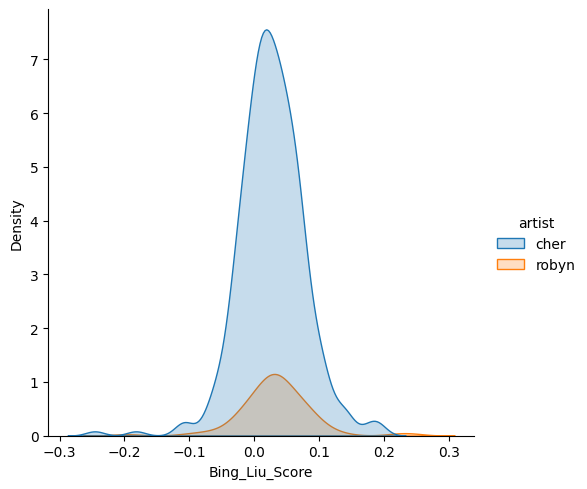

In [18]:
# Density of score by artist.
sns.displot(lyrics_sentiment_df, x="Bing_Liu_Score", hue="artist", kind="kde", fill=True)

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [19]:
# Here I want to get some of the emjois used from the corpose to select what I want to use for my analysis.
# twitter_df

my_emoji_dict = emoji.emoji_list(twitter_dict['cher'])
my_emoji_dict.extend(emoji.emoji_list(twitter_dict['cher']))

# Get all the emojis from our corpus to find the top 10.
res = []
for idx, sub in enumerate(my_emoji_dict, start = 0):
    res.extend(sub['emoji'])


c = Counter(res)
n = 100
print("Most Common:", c.most_common(n))
print("Least Common:",c.most_common()[:-n-1:-1])

Most Common: [('❤', 1264), ('✨', 1208), ('🖤', 980), ('🦋', 932), ('😎', 836), ('♥', 752), ('🌈', 744), ('✌', 732), ('🌻', 700), ('🤍', 508), ('😀', 496), ('💜', 480), ('👽', 456), ('🤠', 452), ('😍', 444), ('💕', 428), ('🌹', 424), ('🙃', 400), ('😁', 360), ('💙', 356), ('😊', 348), ('💋', 320), ('🦄', 320), ('💖', 312), ('🌸', 300), ('👑', 300), ('🌞', 296), ('🥰', 292), ('🌙', 276), ('👀', 268), ('😘', 256), ('🤡', 248), ('🌱', 244), ('🙂', 236), ('😇', 232), ('🥀', 232), ('😃', 228), ('💛', 224), ('🤪', 224), ('☺', 224), ('🙄', 212), ('🐝', 208), ('🤓', 208), ('😜', 208), ('😉', 196), ('💚', 188), ('💗', 188), ('💫', 188), ('🤔', 188), ('💀', 184), ('🌊', 180), ('😈', 180), ('🍒', 176), ('👻', 164), ('🤗', 164), ('🥴', 152), ('🍀', 148), ('🔥', 144), ('🌚', 140), ('🌺', 136), ('🪐', 128), ('😋', 124), ('🦂', 120), ('💞', 120), ('🕊', 120), ('🔮', 120), ('🌿', 116), ('🦦', 112), ('🌵', 112), ('🦁', 108), ('🤩', 108), ('😂', 104), ('🐶', 104), ('💯', 100), ('👍', 100), ('🔞', 96), ('♏', 96), ('😄', 96), ('🌟', 96), ('👾', 96), ('🫀', 92), ('♉', 92), ('👋', 9

In [20]:
pos_emojis_set = {'😂':1,
'❤️':1,
'😍':1,
'♥️':1,
'😊':1,
'💕':1,
'😉':1,
'🤩':1,
'🤍':1,
'🎉':1,}

neg_emojis_set = {'😭':-1,
'😔':-1,
'🥺':-1,
'😩':-1,
'💔':-1,
'😡':-1,
'😠':-1,
'😢':-1,
'😤':-1,
'😬':-1,}

pos_neg_emojis_set = {**pos_emojis_set, **neg_emojis_set}
pos_neg_emojis_set 


{'😂': 1,
 '❤️': 1,
 '😍': 1,
 '♥️': 1,
 '😊': 1,
 '💕': 1,
 '😉': 1,
 '🤩': 1,
 '🤍': 1,
 '🎉': 1,
 '😭': -1,
 '😔': -1,
 '🥺': -1,
 '😩': -1,
 '💔': -1,
 '😡': -1,
 '😠': -1,
 '😢': -1,
 '😤': -1,
 '😬': -1}

In [21]:
# Tokenized emoji Data
twitter_df['emoji'] = twitter_df['description'].map(emoji.distinct_emoji_list)

In [22]:
# Helper Function - Get Emoji Counts
def emoji_count(text, emoji_dict):
    sentiment_score = 0
    bag_of_emojis = text
    for e in bag_of_emojis:
        if e in emoji_dict:
            sentiment_score += emoji_dict[e]
    return sentiment_score


In [23]:
# Count all positive and negative Emojis 
twitter_df['All_Emoji_Counts'] = twitter_df['emoji'].apply(emoji_count, 
emoji_dict = pos_neg_emojis_set)

# Count all positive Emojis
twitter_df['Pos_Emoji_Counts'] = twitter_df['emoji'].apply(emoji_count, 
emoji_dict = pos_emojis_set)

# Count all negative Emojis
twitter_df['Neg_Emoji_Counts'] = twitter_df['emoji'].apply(emoji_count, 
emoji_dict = neg_emojis_set)

In [24]:
twitter_df[twitter_df['All_Emoji_Counts']>=1].sort_values('All_Emoji_Counts')

,artist,description,emoji,All_Emoji_Counts,Pos_Emoji_Counts,Neg_Emoji_Counts
117,cher,Am sherry Mark Nice meeting lady and single la...,[💕],1,1,0
4711934,cher,Luke 1:45 🤍,[🤍],1,1,0
4711901,cher,"Apex legends, good vibes, animes 💪❤️👌","[💪, 👌, ❤️]",1,1,0
4711671,cher,ATC'19🎓 pretty brown girl👸🏽 Future Nanny👩‍👧 am...,"[🎓, ♥️, 👩‍👧, 🐾, 👸🏽]",1,1,0
4711661,cher,Husky loving agnostic liberal. I don’t care wh...,[😂],1,1,0
...,...,...,...,...,...,...
6570517,cher,"Take a chance, because you never know how perf...","[👩‍⚖️, ❗, 🇵🇷, 🍓, 😋, 🐜, 🎥, 🙊, 🐝, 🌷, ®, ❄️, 🌹, ♥...",8,8,0
2654196,cher,"Take a chance, because you never know how perf...","[👩‍⚖️, ❗, 🇵🇷, 🍓, 😋, 🐜, 🎥, 🙊, 🐝, 🌷, ®, ❄️, 🌹, ♥...",8,8,0
731154,cher,Nada poderá impedir a chegada da primavera” 🌼🌹...,"[🏖, 🇳🇮, ✏, 🌹, ♥, 🐬, 🇳🇱, 🤍, 🦋, 📚, ♀️, ❣️, 💚, 🇨🇦...",8,9,-1
4647475,cher,Nada poderá impedir a chegada da primavera” 🌼🌹...,"[🏖, 🇳🇮, ✏, 🌹, ♥, 🐬, 🇳🇱, 🤍, 🦋, 📚, ♀️, ❣️, 💚, 🇨🇦...",8,9,-1


In [25]:
cher_followers = 4044978
robyn_followers = 350902

import numpy as np

df = twitter_df.groupby('artist').agg({"All_Emoji_Counts":"sum"}).reset_index()

def by_artist_func(df):
    if df['artist'] == 'cher':
        return(df["All_Emoji_Counts"]/cher_followers)
    elif df['artist'] == 'robyn':
        return(df["All_Emoji_Counts"]/robyn_followers)
    
df['Avg_Sentiment'] = df.apply(by_artist_func, axis = 1)

df

,artist,All_Emoji_Counts,Avg_Sentiment
0,cher,129730,0.032072
1,robyn,3333,0.009498


In [26]:
# Emojis for Cher
lst = twitter_df[
    (twitter_df["emoji"].str.len() != 0) & 
    (twitter_df["artist"]=='cher')
    ]["emoji"].explode().to_list()

result = [x for x in lst if x[0] in pos_neg_emojis_set]
c = Counter(result)

pos_result = [x for x in lst if x[0] in pos_emojis_set]
pos_c = Counter(pos_result)

neg_result = [x for x in lst if x[0] in neg_emojis_set]
neg_c = Counter(neg_result)

n = 1
print("Most Common Pos:", pos_c.most_common(n))
print("Most Common Neg:", neg_c.most_common(n))
print("All in Order:", c.most_common(20)) 

Most Common Pos: [('💕', 18172)]
Most Common Neg: [('💔', 2644)]
All in Order: [('💕', 18172), ('😍', 12264), ('😊', 8506), ('🤍', 6728), ('😉', 6370), ('😂', 5550), ('💔', 2644), ('🤩', 1904), ('🎉', 1850), ('🥺', 1176), ('😭', 1136), ('😬', 892), ('😔', 712), ('😢', 612), ('😩', 596), ('😡', 518), ('😤', 418), ('😠', 208)]


In [27]:
# Emojis for Robyn
lst = twitter_df[
    (twitter_df["emoji"].str.len() != 0) & 
    (twitter_df["artist"]=='robyn')
    ]["emoji"].explode().to_list()

result = [x for x in lst if x[0] in pos_neg_emojis_set]
c = Counter(result)

pos_result = [x for x in lst if x[0] in pos_emojis_set]
pos_c = Counter(pos_result)

neg_result = [x for x in lst if x[0] in neg_emojis_set]
neg_c = Counter(neg_result)

n = 1
print("Most Common Pos:", pos_c.most_common(n))
print("Most Common Neg:", neg_c.most_common(n))
print("All in Order:", c.most_common(20)) 

Most Common Pos: [('💕', 372)]
Most Common Neg: [('💔', 54)]
All in Order: [('💕', 372), ('😍', 204), ('😊', 163), ('🤍', 157), ('😉', 131), ('😂', 98), ('🎉', 69), ('💔', 54), ('🤩', 49), ('🥺', 28), ('😬', 28), ('😭', 27), ('😔', 11), ('😩', 10), ('😢', 9), ('😡', 8), ('😤', 8), ('😠', 6)]


Q: What is the average sentiment of your two artists? 

A: The average emoji sentiment for Cher is 0.032072. The average sentiment for Robyn is 0.009498

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: The most popular positive emoji for Cher is '💕'. The most popular negative emoji for Cher is '💔'.

The most popular positive emoji for Robyn is '💕'. The most popular negative emoji for Robyn is '💔'.

The fact that they are the same is more a fact that we used a limited set of the total set of emoji's used.

